In [1]:
import pandas as pd
from IPython.display import display
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats
import numpy as np
import datetime
import matplotlib.dates as mdates
from scipy.fftpack import fft
import matplotlib.patches as mpatches
import matplotlib.colors as mp_colors


import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn.linear_model import LinearRegression

from scipy.signal import butter
from scipy import signal

## Funciones

### missing_per(df)
Esta función calcula el porcentaje de faltantes. Toma como argumento un pandas.DataFrame y devuelve otro con los faltantes por columna.  

### marcha anual(df, est)
Toma como argumento un dataframe y el nombre de la estación (string). Guarda en SALIDAS una imagen png de la marcha anual de temperatura máxima, temperatura mínima y precipitación. 

### pad(df)
Toma como argumento un dataframe. Devuele el mismo dataframe pero con la serie temporal (columa de fechas) completa en caso de que hayan huecos. A las fechas agregadas les pone un NaN en todas las columnas. 

### corr_ests(df1,df2)
Calcula la correlación entre dos estaciones para la precipitación, temperatura mínima y máxima. Toma como argumento dos dataframes (uno de cada estación). Devuelve la correlación (float).

### matriz_corr(var, dic, keys)
Calcula la correlación entre muchas estaciones. Toma como argumento la variable (pp,tmax,tmín,...), un diccionario con todos los dataframe de las estaciones y las claves del diccionario (esto ultimo podría obviarlo ya que se obtiene con dic.keys()). Devuelve una matriz (dataframe) con las correlaciones. 

In [102]:

#Función para contar faltantes 
def missing_per(df):
    
    '''
    Función para contabilizar datos faltantes de todas las variables en porcentaje.
    
    Parámetro:
        df: dataframe de la estación con una columna de fechas (date),
        una de temperatura máxima (tmax) y otra de temp. min. (tmin)
        
    Devuelve:
        p: dataframe con el % de faltantes para tmax, tmin y pp. 
        
    '''
    
    f = df.isnull().sum() #Sumo la cant de nans para cada columna
    
    anio1 = str((df.date.values[0]))
    anio2 = str((df.date.values[-1]))
    time = pd.date_range(anio1, anio2, freq='D')

    
    p = round((f*100)/len(time),2)
    
    p=p[['date','tmax','tmin','pp']]
        
    return(p)
    
def marcha_anual(df, est):
    
    '''
    Función que calcula, grafica y guarda el gráfico de la marcha anual
    de las estaciones en SALIDAS. 
    
    Parámetros:
        df: dataframe de la estación con una columna de fechas (date),
        una de temperatura máxima (tmax) y otra de temp. min. (tmin)
        
    '''
                                
    #Guardo en un dataframe las temp max y min, y en otro la precipitacion
    temp=df[['date','tmax','tmin']]
    pp=df[['date','pp']]
  
    #temp_monthly=temp.resample('M', on='date').mean()
    temp_monthly=temp.groupby(temp['date'].dt.month).mean()
    
    pp_monthly=pp.resample('M', on='date').sum()
    pp_monthly=pp_monthly.groupby(pp_monthly.index.month).mean()
    
    pp_monthly['month']=MES
    temp_monthly['month']=MES
     
    #Grafico precipitación y temperatura en el mismo grafico usando seaborn
    
    sns.set_theme(style='white')
    
    ax1=sns.barplot(data=pp_monthly, x='month', y='pp', ci=None, palette='crest')
    ax2=ax1.twinx()
    sns.lineplot(data=temp_monthly, y='tmax', x='month', marker='o', color='red', ax=ax2)
    sns.lineplot(data=temp_monthly, y='tmin', x='month', marker='o', color='blue', ax=ax2)

    ax1.set(ylim=(0,200), xlabel='Mes', ylabel='Precipitación (mm)')
    ax2.set(ylim=(0,40), ylabel='Temperatura (°C)')
    
    ax1.set_title("Marcha anual "+ est)
    
    fig=ax1.get_figure()
    
    fig.savefig(SALIDAS+'/MarchaAnual_'+est+'.png', dpi=600, bbox_inches='tight')

def pad(df):
    
    '''
    Función para agregar fechas faltantes a la serie en caso de que 
    estuviese incompleta. Rellena las columnas con nans. De esta manera se
    contabilizará correctamente los datos faltantes
    
    Parámetro:
        df: dataframe de la estación que tenga una columna de fechas (dates)
    
    Devuelve:
        df_comp: dataframe con la serie temporal completa
    '''
    
    
    i=str(df.date.values[0]) #Primer fecha
    f=str(df.date.values[-1]) #Ultima fecha
    
    #array de fechas desde i hasta f con frecuencia diaria
    #comp = pd.to_datetime(pd.date_range(i, f, freq='D')).dt.date
    comp = np.arange(i, f, dtype='datetime64[D]')
    #Comparo el largo del array creado antes con el dataframe
    print('La diferencia de fechas es de '+str(len(comp)-len(df))+'\n')
    
    #Borro las fechas duplicadas
    df_comp = df.set_index('date')
    df_comp = df_comp.loc[~df_comp.index.duplicated(), :]
    #Reindexeo con la serie temporal completa llenando los vacios con 'S/D'
    df_comp = df_comp.reindex(comp,fill_value='S/D')
    
    #Cambio 
    df_comp['date']=comp
    
 
    return df_comp

def corr_ests(est1,est2):
    
    index = np.arange('1970-01-01', '2021-06-30', dtype='datetime64[D]')
    VAR = ['pp','tmax','tmin']
    corrs = pd.DataFrame({'Variable':VAR, 'Corr':[99.111,99.111,99.111]})
    i=0
    
    a = est1
    b = est2
    
    #Pongo a la columna de fechas como índice
    a = a.set_index('date')
    #Elimino los indices duplicados
    a = a.loc[~a.index.duplicated(), :]
    b = b.set_index('date')
    b = b.loc[~b.index.duplicated(), :]
    
    #Reindexeo con la serie temporal completa, de esta forma solo se agregarán las fechas faltantes
    a = a.reindex(index)
    b = b.reindex(index)
    
    #Paso de null a not a number
    a[b.isnull()] = np.nan
    b[a.isnull()] = np.nan
    
    #Elimino los na
    a = a.dropna()
    b = b.dropna()
    
    #Recorro el diccionario calculando la correlación 
    for var in VAR:
        
        corr, p_value = stats.pearsonr(a[var],b[var])
        corrs.Corr[i] = a[var].corr(b[var],method='pearson')
        print(a[var].corr(b[var],method='pearson'))
        
        i=i+1
        
    return corrs

def anomaly(df):
    
    '''
    Función que calcula las anomalías mensuales respecto del valor medio mensual. 
    '''
    
    #Agrego una columna de meses
    df['month'] = pd.DatetimeIndex(df['date']).month
    
    #Agrupo por mes y calculo la media
    monthly_means = df.groupby('month').mean()
    monthly_means.head()
    for i in range(12):
        df['tmax'][df.month == i+1] = df['tmax'] - monthly_means.iloc[i,0]
        df['tmin'][df.month == i+1] = df['tmin'] - monthly_means.iloc[i,1]
        df['pp'][df.month == i+1]  = df['pp'] - monthly_means.iloc[i,2]
    
    del monthly_means
        
    return df

def corr_matriz(dic,var):
    
    '''
    Función que correlaciona series entre si y devuelve una matriz de filasxcolumnas con 
    el nombre de las estaciones y la correlación.
    
    Parámetros: 
        dic: diccionario tipo "nombre de la estacion":dataframe_datos.
        var: que variable hay que correlacionar (nombre de la columna)
    
    Devuelve:
        matriz de correlaciones y matriz con pvalue
    '''
    
    #Primer paso: igualar serie temporal
    index = pd.to_datetime(np.arange('1970-01-01', '2021-06-30', dtype='datetime64[M]'))


    #Creo un df donde se guardara la serie temporal de cada estación,
    #inicializandolo como una serie de fechas.
    df_datos = pd.DataFrame({'date':index})
    df_datos = df_datos.set_index('date')
    df_datos.head()


    for key in EST2:
        df = dic[key]
        df['date'] = df.index
        mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2017-1-1')))
        df['date'] = pd.to_datetime(df['date'])
        df = df.loc[mask]
        df_datos[key] = df[var] #Lo agrego como nueva columna al df incializado antes

    
    #Creo dos dataframes vacíos, donde en las filas y en las columnas estén las estaciones. 
    #Una para guardar la correlación y en el otro, el nivel de significancia.
    corr_matriz = np.zeros((len(EST2),len(EST2)))
    pvalue_matriz = np.zeros((len(EST2),len(EST2)))
    
    i=0 #Va a recorrer las filas de las matrices de correlación y pvalue
    j=0 #Va a recorrer las columnas de las matrices de correlación y pvalue
    
    for est1 in EST2:
        j=0
        for est2 in EST2:
            #Guardo en dos variables a parte, 2 estaciones
            a = df_datos[est1]
            b = df_datos[est2]

            #Pongo nans en a, donde b tenga nans y viceversa,
            #porque la función de scipy no soporta series con
            #datos faltantes
            a[b.isnull()] = np.nan
            b[a.isnull()] = np.nan

            #Elimino los nan, y me quedan dos series con las
            #mismas fechas y sin nans
            a = a.dropna()
            b = b.dropna()

            #Calculo la correlación con scipy
            corr,pvalue = stats.pearsonr(a,b)

            #Guardo la correlación y la significancia en las
            #matrices de ceros definidas antes.
            corr_matriz[i][j] = corr
            #print(var)
            pvalue_matriz[i][j] = pvalue
            #print(pvalue)
            #print(pvalue_matriz[i][j])

            #Me muevo a la siguiente columna
            j+=1

            del a,b
                
        #Me muevo a la siguiente fila    
        i+=1
            
    corr_matriz = pd.DataFrame(corr_matriz, columns = EST2, index = EST2).round(2)
    pvalue_matriz = pd.DataFrame(pvalue_matriz, columns = EST2, index = EST2).round(2)
       
    
    return corr_matriz, pvalue_matriz
            
def linear_trend(df, var, sen=False):
    
    '''
    Función que calcula la tendencia lineal por metodo de
    cuadrados minimos si sen=False. Si sen=True, calcula la
    pendiente mediante el estimador de Theil-Sen. 
    
    Parametros: 
        df: dataframe cuyo indice sea la fecha
        car: variable (tmax, tmin, pp)
        sen: True para tendencia por estimador Theil-Sen. False para
        metodo de cuadrados minimos. 
        
    Devuelve: si sen=False, tendencia y pvalue. Si sen=True, tendencia. 
    '''
    
    #Quito los nans
    df.dropna(subset = [var], inplace=True)
    
    if not sen:    
        #Hago una regresión lineal entre el tiempo y la variable usando scipy
        trend, y, rvalue, pvalue, z = stats.linregress(np.arange(len(df)), df[var])
        return trend, y, pvalue
    
    else:
        trend, y = stats.theilslopes(df[var], np.arange(len(df)))[:2]
        return trend, y


        

def mapa_tendencias_cmap(tabla, nombre_var, cmap, unidad, precip=False):
    
    
    '''
    Función que realiza un scatter plot de las tendencias de cada 
    estación, y el tamaño de cada marcador sera proporcional a la tendencia.
    El color indica si es tendencia positiva o negativa.
    
    La figura es guardada en SALIDAS
    
    Parámetros:
        tabla: tabla de tendencias (filas estaciones, columnas de corr. y pvalue)
        nombre_var: string con el nombre de la variable para poner en el titulo
        cmap: colormap de matplotlib para colorear los circulos
        unidad: unidad de la tendencia (ej. °C/decada)
    '''
    
    tendencias = ['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']
    pvalues = ['pvalue_mensual', 'pvalue_DJF', 'pvalue_MAM', 'pvalue_JJA', 'pvalue_SON']
    
    #Grafico para cada variable (mensual o estacional)
    j=0
    for x in tendencias:
        
        edge = []
        
        for i in tabla.index:
        
            #Bordes
            if tabla[pvalues[j]][i]>0.051:
                edge.append('white')
            else:
                edge.append('k')
    
    
        #Creamos la figura y definimos su tamaño
        fig = plt.figure(figsize=(3.3, 5.3))

        ax=plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
        crs_latlon = ccrs.PlateCarree()
        ax.set_extent([360-67,360-59, -35, -25], crs=crs_latlon)
        
        #Normalización de colores 
        if precip:
            norm = mp_colors.Normalize(vmin=-40, vmax=40)
            a = 15
        else:
            norm = mp_colors.Normalize(vmin=-0.4, vmax=0.4)
            a = 810



        #Agrego bordes de costas, países y provincias
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)

        states_provinces = cartopy.feature.NaturalEarthFeature(
              category='cultural',
              name='admin_1_states_provinces_lines',
              scale='10m',
              facecolor='none')

        ax.add_feature(states_provinces, edgecolor='gray')
        
        #Configuro el gráfico

        ax.set_xticks([295, 300], crs=crs_latlon)
        ax.set_yticks([-35,-30, -25], crs=crs_latlon)
        ax.grid(which='both', linewidth=0.3, linestyle='-')
        ax.tick_params(axis='both', which='major', labelsize=6)
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)

        #Ahora hago el scatter plot
        plt.scatter(tabla['lon'], tabla['lat'], s=abs(tabla[x]*a), c=tabla[x], cmap = cmap, 
                    norm = norm,
                    linewidths = 2, edgecolors = edge,
                    transform=ccrs.PlateCarree())
        
        #Titulo        
        ax.set_title('Tendencia '+nombre_var+' '+x[5:])
    
        cbar = plt.colorbar(orientation="vertical",fraction=0.055,anchor=(1.0,0.0))
        cbar.set_label(unidad, rotation=270)


        #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        #Guardo la figura 
        fig.savefig(SALIDAS + 'Mapa_Tendencias/Mapa_'+x+'_'+nombre_var+'.png', dpi=300, bbox_inches='tight')
        

## Constantes

In [68]:
#Directorio a los datos
DATOS1='/home/dalia.panza/Proy_IAI/Datos/SMN/Exp186974.xlsx'
DATOS2='/home/dalia.panza/Proy_IAI/Datos/SMN/Exp186974_Parte2.xlsx'
DATOS_BRENIAS = '/home/dalia.panza/Proy_IAI/Datos/SMN/NH0416.xls'
DATOS_PP_GPCC='/datos/Datos_Dalia/precip.mon.total.v2018.nc'

#Directorio a la carpeta con salidas
SALIDAS='/home/dalia.panza/Proy_IAI/Salidas/SMN/'

# Para serie temporal de anomalias CENTRO ARGENTINA
LAT_SUR_M=-35
LAT_NOR_M=-26
LON_OESTE_M=294
LON_ESTE_M=299

#Para calculos 
LAT_SUR=-42
LAT_NOR=-16
LON_OESTE=287
LON_ESTE=306

#Periodo correlaciones
ANIO_MIN=1970
ANIO_MAX=2021

#Periodo correlaciones en formato
TIMEMIN = str(ANIO_MIN)+'-01-01'
TIMEMAX = str(ANIO_MAX)+'-06-30'

#Periodo en el cual se calculará la media para las anomalías
TIMEMIN_MEDIA = '1951-01-01'
TIMEMAX_MEDIA = '1980-12-31'

#Meses
MES=['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']

#Vector con el nombre de todas las estaciones brindadas
EST=['Santiago del Estero', 'Villa Maria del Rio Seco', 'Cordoba aero',
     'Cordoba observatorio','Escuela de Aviación militar', 'Pilar observatorio', 'Villa Dolores aero',
     'Río Cuarto aero', 'San Luis aero', 'Laboulaye aero', 'Villa Reynolds aero', 'Marco Juarez aero',
     'Termas de Rio Hondo', 'Chamical', 'Roque Saenz Peña aero', 'Santa Rosa de Conlara aero', 'Las Breñas']

#Vector con los nombres de la subselección de estaciones para correlacionar
EST2=['Santiago del Estero','Cordoba aero','Cordoba observatorio', 'Pilar observatorio',
      'Villa Dolores aero','Río Cuarto aero', 'San Luis aero', 'Laboulaye aero',
      'Villa Reynolds aero', 'Marco Juarez aero','Chamical', 'Las Breñas']

#Vector con el nombre de todas las variables brindadas
COLS=['station','date','tmax','tmin','tmedia','pp', 'heliofania','direc_vmax','int_vmax', 'int_vmedio', 'trocio_media', 'pmedia', 
            'pmedia_nm', 'hr_media', 'nubosidad', 'ndatos']

#Vector con el nombre de las variables que voy a utilizar
VAR=['max','min','pp']

#Vector con nombres de las estaciones del año
KEYS=['Verano (DJF)', 'Otoño (MAM)', 'Invierno (JJA)', 'Primavera (SON)']

## Lectura de datos de estaciones

Lectura de datos, renombramiento de columnas y creación de diccionarios, uno con todas las estacionesy otro con los detalles de localización para crear mapa. 

In [4]:
#Lectura de datos 
df1 = pd.read_excel(DATOS1,0)
df2 = pd.read_excel(DATOS2)
df_detalles = pd.read_excel(DATOS1,1, usecols=[0,1,2,3])

#Datos de Las Breñas
brenias = pd.read_excel(DATOS_BRENIAS,0)
detalles_brenias = pd.read_excel(DATOS_BRENIAS,1)

#Las Breñas es una estación del INTA, por eso está a parte. Me quedó con las columnas 0(fecha), 2(tmax)
#3(tmin) y 11(precip)
brenias = brenias.iloc[:, [0,2,3,11]]

#Le cambio el nombre a las columnas
brenias.columns = ['date', 'tmax', 'tmin', 'pp']
print(brenias)

#De los detalles de Las Breñas selecciono las columnas 5 y 6 (latitud y longitud)
detalles_brenias = detalles_brenias.iloc[:,[5,6]]
detalles_brenias.columns = ['lat','lon']

detalles_brenias = detalles_brenias*(-1)
#print(brenias)
#print(detalles_brenias)



#Renombro las columnas
df1.columns=COLS
df2.columns=COLS
#Reemplazo el nombre de las columnas
df_detalles.columns = ['station','name','lat','lon']

#Cambio la clase de las fechas a datetime
df1['date'] = pd.to_datetime(df1['date']).dt.date
df2['date'] = pd.to_datetime(df2['date']).dt.date
brenias['date']= pd.to_datetime(brenias['date']).dt.date
#df['date']=pd.to_datetime(df['date'], format='%d/%m/%Y').dt.dat
#df1['date']=pd.to_datetime(df['date'], format='%d/%m/%Y')
#df2['date']=pd.to_datetime(df['date'], format='%d/%m/%Y')

df=df2.append(df1, ignore_index=True)
#La estacion 10034 cierra el 8/9/1998 y abre la estación 17970 en su lugar. 
#Entonces le cambio el numero de estación 10034 --> 17970 para facilitar el 
#analisis (como si fueran la misma estación)

df.loc[df.station==10034,"station"]= 17970


#Separo los datos por estación almacenandolos en un diccionario
estaciones = {EST[0]:df[df.station.eq(10062)],
              EST[1]:df[df.station.eq(10082)],
              EST[2]:df[df.station.eq(10100)],
              EST[3]:df[df.station.eq(10105)],
              EST[4]:df[df.station.eq(10107)],
              EST[5]:df[df.station.eq(10111)],
              EST[6]:df[df.station.eq(10117)],
              EST[7]:df[df.station.eq(10138)],
              EST[8]:df[df.station.eq(10139)],
              EST[9]:df[df.station.eq(10148)],
              EST[10]:df[df.station.eq(10335)],
              EST[11]:df[df.station.eq(10369)],
              EST[12]:df[df.station.eq(10458)],
              EST[13]:df[df.station.eq(10476)],
              EST[14]:df[df.station.eq(17970)],
              EST[15]:df[df.station.eq(18030)],
              EST[16]:brenias}

detalles = {EST[0]:df_detalles[df_detalles.station.eq(10062)],
            EST[1]:df_detalles[df_detalles.station.eq(10082)],
            EST[2]:df_detalles[df_detalles.station.eq(10100)],
            EST[3]:df_detalles[df_detalles.station.eq(10105)],
            EST[4]:df_detalles[df_detalles.station.eq(10107)],
            EST[5]:df_detalles[df_detalles.station.eq(10111)],
            EST[6]:df_detalles[df_detalles.station.eq(10117)],
            EST[7]:df_detalles[df_detalles.station.eq(10138)],
            EST[8]:df_detalles[df_detalles.station.eq(10139)],
            EST[9]:df_detalles[df_detalles.station.eq(10148)],
            EST[10]:df_detalles[df_detalles.station.eq(10335)],
            EST[11]:df_detalles[df_detalles.station.eq(10369)],
            EST[12]:df_detalles[df_detalles.station.eq(10458)],
            EST[13]:df_detalles[df_detalles.station.eq(10476)],
            EST[14]:df_detalles[df_detalles.station.eq(17970)],
            EST[15]:df_detalles[df_detalles.station.eq(18030)],
            EST[16]:detalles_brenias}

print(detalles[EST[16]])

                        date  tmax  tmin    pp
0      1967-01-01 00:00:00.0  22.8  17.4   4.2
1      1967-01-02 00:00:00.0  29.4  19.8  70.0
2      1967-01-03 00:00:00.0  27.0  19.9  12.9
3      1967-01-04 00:00:00.0  31.1  15.5   0.0
4      1967-01-05 00:00:00.0  31.0  16.2   0.0
...                      ...   ...   ...   ...
20089  2022-01-02 00:00:00.0  32.5  21.0   2.2
20090  2022-01-03 00:00:00.0  32.9  21.0   0.0
20091  2022-01-04 00:00:00.0  34.3  20.8   0.0
20092  2022-01-05 00:00:00.0  33.3  21.8   0.0
20093  2022-01-06 00:00:00.0  32.2  15.7   0.0

[20094 rows x 4 columns]
    lat        lon
0  27.1  61.099998


## Mapa con ubicación de estaciones

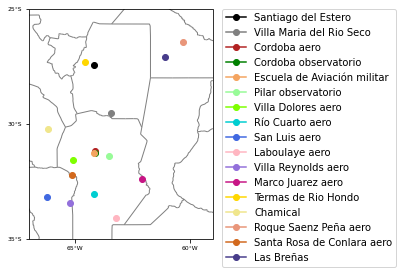

In [5]:
# print(df_detalles.lat.min())
# print(df_detalles.lat.max())
# print(df_detalles.lon.min())
# print(df_detalles.lon.max())

 #Creamos la figura y definimos su tamaño
fig = plt.figure(figsize=(3.3, 5.3))

ax=plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
crs_latlon = ccrs.PlateCarree()
ax.set_extent([360-67,360-59, -35, -25], crs=crs_latlon)


#Agrego bordes de costas, países y provincias
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cartopy.feature.NaturalEarthFeature(
      category='cultural',
      name='admin_1_states_provinces_lines',
      scale='10m',
      facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')

ax.set_xticks([295, 300], crs=crs_latlon)
ax.set_yticks([-35,-30, -25], crs=crs_latlon)
ax.grid(which='both', linewidth=0.3, linestyle='-')
ax.tick_params(axis='both', which='major', labelsize=6)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

colors=['k','gray','firebrick','green','sandybrown','palegreen',
         'chartreuse','darkturquoise','royalblue', 'lightpink','mediumpurple',
         'mediumvioletred','gold','khaki','darksalmon','chocolate', 'darkslateblue']
i=0
for key in detalles.keys():
    lat=detalles[key].lat.values*(-1)
    lon=360-detalles[key].lon.values
    
    ax.plot(lon,lat,color=colors[i],
            marker='o',markersize=6,
            transform=crs_latlon,label=str(key))
    i=i+1

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.savefig(SALIDAS + '/Mapa.png', dpi=300, bbox_inches='tight')

## Arreglo de los datos

1. Visualización de fecha inicial y final de cada estación por consola
2. Se completa la serie temporal de cada estación usando pad(df)
3. Los elementos vacíos de precipitación se cambian por ceros, los S/D se cambian por -999 y las columnas se cambian a tipo float. Los -999 se reemplazan con NaNs
4. Visualización de porcentaje de faltantes con la función missing_per(df)

Todo esto se realiza para temperatura máxima, mínima y precipitación. 

In [6]:
#Primera y ultima fecha del registro
for key in EST:
    i=estaciones[key].date.values[0]
    f=estaciones[key].date.values[-1]
    print("\n"+str(key)+": \n"+ 
          str(i)+ "\n"+
          str(f)+"\n")
    
    
    del i,f


#Si hay saltos en la serie temporal uso la función pad para completarla 
for key in estaciones.keys():
    print(key)
    estaciones[key]=pad(estaciones[key])

#Arreglo a serie 
for key in estaciones.keys():
    estaciones[key][['tmax','tmin','pp']] = estaciones[key][['tmax','tmin','pp']].replace(' ','0') #Reemplazo vacios por '0'
    estaciones[key][['tmax','tmin','pp']] = estaciones[key][['tmax','tmin','pp']].replace('S/D','-999') #Reemplazo S/D por '-1'
    estaciones[key][['tmax','tmin','pp']] = estaciones[key][['tmax','tmin','pp']].astype(float) #Paso a int
    estaciones[key][['tmax','tmin','pp']] = estaciones[key][['tmax','tmin','pp']].replace(-999,np.nan) #Reemplazo -1 por nan


#Veo los faltantes por estación
for key in estaciones.keys():
    p=missing_per(estaciones[key])
    print("\n"+str(key))
    print(p[['tmin','tmax','pp']])
    
    del p


Santiago del Estero: 
1931-01-01
2021-10-01


Villa Maria del Rio Seco: 
1931-01-01
2021-10-01


Cordoba aero: 
1956-02-01
2021-10-01


Cordoba observatorio: 
1956-04-05
2021-10-01


Escuela de Aviación militar: 
1956-02-01
2021-10-01


Pilar observatorio: 
1925-02-01
2021-10-01


Villa Dolores aero: 
1930-01-01
2021-10-01


Río Cuarto aero: 
1931-01-01
2021-10-01


San Luis aero: 
1931-01-01
2021-10-01


Laboulaye aero: 
1939-08-23
2021-10-01


Villa Reynolds aero: 
1956-02-01
2021-10-01


Marco Juarez aero: 
1952-07-01
2021-10-01


Termas de Rio Hondo: 
1961-05-01
2021-10-01


Chamical: 
1962-11-01
2021-10-01


Roque Saenz Peña aero: 
1931-01-01
2021-10-01


Santa Rosa de Conlara aero: 
2001-12-20
2021-10-01


Las Breñas: 
1967-01-01
2022-01-06

Santiago del Estero
La diferencia de fechas es de 127

Villa Maria del Rio Seco
La diferencia de fechas es de 230

Cordoba aero
La diferencia de fechas es de 0

Cordoba observatorio
La diferencia de fechas es de 441

Escuela de Aviación mili

## Gráfico de faltantes
Es una serie temporal, en la que si hay dato se grafica una barra azul y si no hay dato no se grafica nada. De esta forma viendo los espacios en blanco se puede tener un pantallazo de períodos con muchos faltantes y descartar períodos/estaciones (temperatura máxima y mínima)

No se hizo para precipitación ya que, observando la cantidad de datos faltantes, era muy baja. 

In [7]:
#%%

# #Ploteo los datos faltantes para ver si hay un periodo que no se pueda usar

# for key in estaciones.keys():
    
#     #Inicializo figura y ejes
#     fig, ax = plt.subplots()
    
#     #Inicializo una grilla para los subplots
#     gs = gridspec.GridSpec(2,1)   
    
#     #Grafico los datos faltantes de tmax, 0=NaN, 1!=NaN. 
    
#     #Me posiciono en el primer subplot
#     ax = plt.subplot(gs[0])
#     #Inicializo un grafico de barras, eje x fecha, eje y datos de tmax como
#     #booleans (True=1, False=0)
#     bar = ax.bar(estaciones[key].date,
#                   estaciones[key]['max'].notnull().astype(int),
#                   width=1)
#     #Titulo
#     ax.set_title( 'Max' , fontsize=12)
#     ax.set_xlim(estaciones[key].date.values[0],
#                 estaciones[key].date.values[-1])
    
#     ax.axes.yaxis.set_visible(False)
    
#     #Grafico los datos faltantes de tmin
    
#     #Me posiciono en el segundo subplot
#     ax = plt.subplot(gs[1])
#     bar = ax.bar(estaciones[key].date,
#                   estaciones[key]['min'].notnull().astype(int),
#                   width=1)
#     ax.set_title( 'Min' , fontsize=12)
#     ax.set_xlim(estaciones[key].date.values[0],
#                 estaciones[key].date.values[-1])
        
#     ax.axes.yaxis.set_visible(False)
     
#     fig.suptitle("Faltantes "+str(key), fontsize=18)
#     fig.subplots_adjust(left=0.05, bottom=0.08, right=0.98,top=0.85, wspace=0.5 ,hspace=0.35)
    
#     fig.savefig(SALIDAS+"/Faltantes_"+str(key)+".png")

#     plt.show()

## Correlación entre estaciones y datos de precipitación de GPCC

Con el gráfico de faltantes, se descartaron algunas estaciones y se seleccionó un período donde la mayoría de las estaciones tenian datos (a ojo, no se estableció ningún criterio). El período es (01/01/1970-30/06/2016), como voy a comparar datos de GPCC tengo como limite 2016. 
Entonces, primero se seleccionan las estaciones (EST2), luego se calcula la correlación para las variables precipitación, temperatura máxima y temperatura mínima con la función matriz_corr(var,dic,keys).  

In [8]:
# Abro el archivo usando xarray
ds_pp=xr.open_dataset(DATOS_PP_GPCC)
#Recorte temporal y espacial
pp_recorte = ds_pp.sel(lat=slice(LAT_NOR, LAT_SUR), lon=slice(LON_OESTE,LON_ESTE), time=slice(TIMEMIN,TIMEMAX))['precip']

del ds_pp
#Remuestreo los datos dividiendo por estaciones (DEF-MAM-JJA-SON)
pp_est = pp_recorte.resample(time="QS-DEC").sum()

pp_est={KEYS[0]:pp_est.sel(time=pp_est["time.month"]==12),
        KEYS[1]:pp_est.sel(time=pp_est["time.month"]==3),
        KEYS[2]:pp_est.sel(time=pp_est["time.month"]==6),
        KEYS[3]:pp_est.sel(time=pp_est["time.month"]==9)}

#Excluyo el primer y ultimo datos de verano (Tienen meses creados que no estan en los datos)
pp_est[KEYS[0]]=pp_est[KEYS[0]].sel(time=slice(pp_est[KEYS[0]]['time'][1],
                                                pp_est[KEYS[0]]['time'][-2]))


#Anomalía para cada punto de reticula

"""Para la serie original"""
pp_media = pp_recorte.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                               lon=slice(LON_OESTE_M,LON_ESTE_M)).mean()
pp_anom = pp_recorte - pp_media

"""Por estación"""
#Inicializo lista vacia 
pp_est_anom=[]

#Ciclo para iterar en el diccionario de datos de pp
for key in KEYS:
    #Hago un recorte espacial para el centro de Arg y el periodo 51-80
    pp_media = pp_est[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                               lon=slice(LON_OESTE_M,LON_ESTE_M)).mean()
    #A la lista vacía le agrego la anomalía para la estación correspondiente
    pp_est_anom.append(pp_est[key]-pp_media)
    
    del pp_media

#Paso de list a dict 
pp_est_anom= dict(zip(KEYS, pp_est_anom))


#Promedio regional con pesos segun latitud
weights = np.cos(np.deg2rad(pp_recorte.lat))

"""Para la serie original"""
pp_anom_PromReg = pp_anom.sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                          lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights).mean(("lon", "lat"))
                          
pp_anom_PromReg = pp_anom_PromReg.to_dataframe()
pp_anom_PromReg['date'] = pd.to_datetime(pp_anom_PromReg.index)
pp_anom_PromReg = pp_anom_PromReg.rename(columns={'precip': 'pp'})

"""Por estación"""
#Inicializo lista vacía
pp_anom_est_PromReg=[]

#Data array con valores entre 0 y 1 para hacer promedio con peso x latitud

for key in KEYS:
    da_weighted = pp_est_anom[key].sel(lat=slice(LAT_NOR_M,LAT_SUR_M),
                                      lon=slice(LON_OESTE_M,LON_ESTE_M)).weighted(weights)
    pp_anom_est_PromReg.append(da_weighted.mean(("lon", "lat")))

                      
#Paso de list a dict
pp_anom_est_PromReg= dict(zip(KEYS, pp_anom_est_PromReg))

#del pp_recorte, ds_weighted, pp_est_anom, pp_est

#Paso los DataArrays a pandas DataFrames
for key in KEYS:
    pp_anom_est_PromReg[key] = pp_anom_est_PromReg[key].to_dataframe().rename(columns={'precip': 'pp'})
    pp_anom_est_PromReg[key][['tmax', 'tmin']] = -999
    pp_anom_est_PromReg[key]['date'] = pd.to_datetime(pp_anom_est_PromReg[key].index)

    

In [9]:
#Creo un nuevo diccionario a partir del anterior con la subselección de estaciones
estaciones2 = {key: estaciones[key] for key in EST2}

#Remuestreo los datos diarios a mensuales
est2_mensual = []

for key in EST2:
    df = estaciones2[key]
    df['date'] = pd.date_range(str(df.date[0]),str(df.date[-1]))
    #df['month'] = pd.date_range(str(df.date[0]),str(df.date[-1])).month
    df_monthly = estaciones2[key][['tmax','tmin']].resample('MS').mean()
    df_monthly['pp'] = estaciones2[key][['pp']].resample('MS').sum()
    df_monthly['date'] = df['date']
    
    est2_mensual.append(df_monthly)
    
    del df

#Paso de list a dictionary
est2_mensual = dict(zip(EST2,est2_mensual))


#Calculo de anomalías
est2_anom_mensual = []

for key in EST2:
    
    anoms = anomaly(est2_mensual[key])
    est2_anom_mensual.append(anoms)
    
    del anoms

est2_anom_mensual = dict(zip(EST2,est2_anom_mensual))

#Calculo de correlación y pvalue
corr_tmax_anom, pvalue_tmax_anom = corr_matriz(est2_anom_mensual,'tmax')
corr_tmin_anom, pvalue_tmin_anom = corr_matriz(est2_anom_mensual,'tmin')

#Agrego los datos de GPCC
est2_anom_mensual['GPCC'] = pp_anom_PromReg
#Agrego GPCC al vector EST2 para poder iterar de manera completa
EST2.append('GPCC')

corr_pp_anom, pvalue_pp_anom = corr_matriz(est2_anom_mensual,'pp')

#Guardo las matrices obtenidas como archivo csv
corr_tmax_anom.to_csv(SALIDAS+'/Correlaciones_scipy_Anom_Tmax.csv')
corr_tmin_anom.to_csv(SALIDAS+'/Correlaciones_scipy_Anom_Tmin.csv')
corr_pp_anom.to_csv(SALIDAS+'/Correlaciones_scipy_Anom_PP.csv')

pvalue_tmax_anom.to_csv(SALIDAS+'/Pvalue_scipy_Anom_Tmax.csv')
pvalue_tmin_anom.to_csv(SALIDAS+'/Pvalue_scipy_Anom_Tmin.csv')
pvalue_pp_anom.to_csv(SALIDAS+'/Pvalue_scipy_Anom_PP.csv')

del corr_tmax_anom, pvalue_tmax_anom,corr_tmin_anom, pvalue_tmin_anom,corr_pp_anom, pvalue_pp_anom




/tmp/ipykernel_11459/368911095.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tmax'][df.month == i+1] = df['tmax'] - monthly_means.iloc[i,0]
/tmp/ipykernel_11459/368911095.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tmin'][df.month == i+1] = df['tmin'] - monthly_means.iloc[i,1]
/tmp/ipykernel_11459/368911095.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pp'][df.month == i+1]  = df['pp'] - monthly_me

In [10]:
#Al hacer las series temporales que siguen, veo que para las estaciones Laboulaye y Cordoba observatorio
#Para el primer mes no se calculan las anomalías. No se porque, lo unico que tienen en comun es que 
#en los datos diarios no esta el mes completo. Pero no entiendo porque no los agrupa. 
#Los saco y listo


df = est2_mensual['Cordoba observatorio']
print(df.loc[df['tmax'].idxmax(), :])
print(df)
est2_mensual['Cordoba observatorio'] = df.drop(df.index[0])
print(est2_mensual['Cordoba observatorio'])

df = est2_mensual['Laboulaye aero']
print(df.loc[df['tmax'].idxmax(), :])
print(df)
est2_mensual['Laboulaye aero'] = df.drop(df.index[0])
print(est2_mensual['Laboulaye aero'])


tmax               22.619231
tmin                8.265385
pp                      18.1
date     1956-04-01 00:00:00
month                    NaN
Name: 1956-04-01 00:00:00, dtype: object
                 tmax      tmin         pp       date  month
date                                                        
1956-04-01  22.619231  8.265385  18.100000 1956-04-01    NaN
1956-05-01  -3.295633 -5.668464  19.695455 1956-05-01    5.0
1956-06-01  -3.502974 -0.267619   5.209091 1956-06-01    6.0
1956-07-01   1.888442 -0.966808  -9.295455 1956-07-01    7.0
1956-08-01  -0.841819 -0.968820  -1.809091 1956-08-01    8.0
...               ...       ...        ...        ...    ...
2021-05-01   0.249529 -0.836206  -0.204545 2021-05-01    5.0
2021-06-01  -0.456308  0.202381  -3.690909 2021-06-01    6.0
2021-07-01   2.706128  0.316062  -9.295455 2021-07-01    7.0
2021-08-01   1.771084  0.021503  -8.909091 2021-08-01    8.0
2021-09-01   1.102154  2.216561  -8.942424 2021-09-01    9.0

[786 rows x 5 column

## Datos estacionales

Ahora se remuestrean los datos, agrupandolos por estación. Trabajo con las anomalías. 

In [11]:
est2_anom_est = []

#Saco 'GPCC' del vector EST2
EST2.pop(-1)

for key in EST2:
    est = est2_anom_mensual[key]
    est1 = est[['tmax','tmin']].resample('QS-DEC').mean()
    est1['pp'] = est['pp'].resample('QS-DEC').sum()
    est2_anom_est.append(est1)
    
    del est, est1

est2_anom_est = dict(zip(EST2,est2_anom_est))

#Separo en cuatro diccionarios los datos para cada estación

est2_anom_DJF = []
est2_anom_MAM = []
est2_anom_JJA = []
est2_anom_SON = []

for key in EST2:
    est = est2_anom_est[key]
    djf = est[(est.index.month == 12)]
    mam = est[(est.index.month == 3)]
    jja = est[(est.index.month == 6)]
    son = est[(est.index.month == 9)]
    
    est2_anom_DJF.append(djf)
    est2_anom_MAM.append(mam)
    est2_anom_JJA.append(jja)
    est2_anom_SON.append(son)
    
    del est,djf,mam,jja,son

est2_anom_DJF = dict(zip(EST2, est2_anom_DJF))
est2_anom_MAM = dict(zip(EST2, est2_anom_MAM))
est2_anom_JJA = dict(zip(EST2, est2_anom_JJA))
est2_anom_SON = dict(zip(EST2, est2_anom_SON))

#Creo un diccionario de diccionarios (primero separado por verano, otoño, invierno y primavera y luego por
#estaciones)
lst = [est2_anom_DJF,est2_anom_MAM,est2_anom_JJA,est2_anom_SON]
est2_anom_est = dict(zip(KEYS,lst))

#Agrego los datos de GPCC
for key in KEYS:
    est2_anom_est[key]['GPCC'] = pp_anom_est_PromReg[key]


#Agrego GPCC al vector de estaciones
EST2.append('GPCC')

#Calculo y guardo las correlaciones y las significancias
for est in KEYS:
   
    #Calculo de correlación y pvalue
    corr_tmax_anom, pvalue_tmax_anom = corr_matriz(est2_anom_est[est],'tmax')
    corr_tmin_anom, pvalue_tmin_anom = corr_matriz(est2_anom_est[est],'tmin')
    corr_pp_anom, pvalue_pp_anom = corr_matriz(est2_anom_est[est],'pp')
    
    #Guardo las matrices obtenidas como archivo csv
    corr_tmax_anom.to_csv(SALIDAS+'/Correlaciones_'+est+'_Anom_Tmax.csv')
    corr_tmin_anom.to_csv(SALIDAS+'/Correlaciones'+est+'Anom_Tmin.csv')
    corr_pp_anom.to_csv(SALIDAS+'/Correlaciones'+est+'Anom_PP.csv')

    pvalue_tmax_anom.to_csv(SALIDAS+'/Pvalue'+est+'Anom_Tmax.csv')
    pvalue_tmin_anom.to_csv(SALIDAS+'/Pvalue'+est+'Anom_Tmin.csv')
    pvalue_pp_anom.to_csv(SALIDAS+'/Pvalue'+est+'Anom_PP.csv')

    del corr_tmax_anom, pvalue_tmax_anom,corr_tmin_anom, pvalue_tmin_anom,corr_pp_anom, pvalue_pp_anom

    

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/tmp/ipykernel_11459/368911095.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a[b.isnull()] = np.nan
/tmp/ipykernel_11459/368911095.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

## Series temporales

Se hará una serie temporal para cada estación, junto con un promedio móvil de 9 años. 

In [12]:
#Saco GPCC del vector de estaciones y veo el largo
EST2.pop(-1)

#Ventana para hacer el promedio movil
window = 108 #Equivale a 9 años

'''Temperatura máxima'''
for key in EST2:

    #Extraigo el df de la estación 
    df = est2_mensual[key][['tmax']]
    #Calculo promedio movil de 9 años, serian 108 meses, agregandolo como nueva columna
    df.loc[:,'PM_max'] = df['tmax'].rolling(window = window, center=True).mean(skipna=False)

    fig, ax = plt.subplots(1,1)
    ax.plot(df.index.values, df.tmax, 'k-', linewidth = .1, color='red')
    ax.plot(df.index.values, df.PM_max, 'k-', linewidth = 1.5, color='red')
    ax.fill_between(df.index.values, df.PM_max, where = df.PM_max>0, color = 'orange')
    ax.fill_between(df.index.values, df.PM_max, where = df.PM_max<0, color = 'skyblue')
    ax.set_xlim(df.index.values[0], df.index.values[-1])
    ax.set_title(key+'\n Temperatura máxima')
    ax.set_ylabel("°C")

    fig.savefig(SALIDAS+'Series_Temporales/SerieTemporal_tmax_mensual_'+key+'.jpg', dpi=300, bbox_inches='tight')
    plt.close(fig)

'''Temperatura minima'''
for key in EST2:

    #Extraigo el df de la estación 
    df = est2_mensual[key][['tmin']]
    #Calculo promedio movil de 9 años, serian 108 meses, agregandolo como nueva columna
    df.loc[:,'PM_min'] = df['tmin'].rolling(window = window, center=True).mean(skipna=False)

    fig, ax = plt.subplots(1,1)
    ax.plot(df.index.values, df.tmin, 'k-', linewidth = .1, color='blue')
    ax.plot(df.index.values, df.PM_min, 'k-', linewidth = 1.5, color='blue')
    ax.fill_between(df.index.values, df.PM_min, where = df.PM_min>0, color = 'orange')
    ax.fill_between(df.index.values, df.PM_min, where = df.PM_min<0, color = 'skyblue')
    ax.set_xlim(df.index.values[0], df.index.values[-1])
    ax.set_title(key+'\n Temperatura minima')
    ax.set_ylabel("°C")

    fig.savefig(SALIDAS+'Series_Temporales/SerieTemporal_tmin_mensual_'+key+'.jpg', dpi=300, bbox_inches='tight')
    plt.close(fig)

'''Precipitación'''
for key in EST2:

    #Extraigo el df de la estación 
    df = est2_mensual[key][['pp']]
    #Calculo promedio movil de 9 años, serian 108 meses, agregandolo como nueva columna
    df.loc[:,'PM_pp'] = df['pp'].rolling(window = window, center=True).mean(skipna=False)

    fig, ax = plt.subplots(1,1)
    ax.plot(df.index.values, df.pp, 'k-', linewidth = .1)
    ax.plot(df.index.values, df.PM_pp, 'k-', linewidth = 1.5)
    ax.fill_between(df.index.values, df.PM_pp, where = df.PM_pp>0, color = 'skyblue')
    ax.fill_between(df.index.values, df.PM_pp, where = df.PM_pp<0, color = 'orange')
    ax.set_xlim(df.index.values[0], df.index.values[-1])
    ax.set_title(key+'\n Precipitación')
    ax.set_ylabel("mm")

    fig.savefig(SALIDAS+'Series_Temporales/SerieTemporal_pp_mensual_'+key+'.jpg', dpi=300, bbox_inches='tight')
    plt.close(fig)

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_11459/2012329471.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df.tmax, 'k-', linewidth = .1, color='red')
/tmp/ipykernel_11459/2012329471.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df.PM_max, 'k-', linewidth = 1.5, color='red')
/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/sit

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_11459/2012329471.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df.tmax, 'k-', linewidth = .1, color='red')
/tmp/ipykernel_11459/2012329471.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df.PM_max, 'k-', linewidth = 1.5, color='red')
/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/sit

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/tmp/ipykernel_11459/2012329471.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df.tmin, 'k-', linewidth = .1, color='blue')
/tmp/ipykernel_11459/2012329471.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df.PM_min, 'k-', linewidth = 1.5, color='blue')
/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/s

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

## Filtro Butterworth

Se aplican a las series un low-pass filter. En este caso el filtro Butterworth, obteniendo los coeficientes correspondientes con la función de scipy.signal.butter. Luego se aplica el filtro con la función signal.filtfilt que devuelve la serie filtrada con las mismas dimensiones que la original. 

In [13]:
#Function to define low pass Butterworth Filter
def butter_filt(x,filt_year,fs,order_butter):
    #fn = fs/2; # Nyquist Frequency
    fc = 1/filt_year # critical frequency
    b, a = signal.butter(order_butter, fc,'low', fs=fs, output='ba')
    return signal.filtfilt(b, a, x)


In [14]:
'''Temperatura máxima'''
for key in EST2:

    #Extraigo el df de la estación 
    df = est2_mensual[key]['tmax']
    #Calculo promedio movil de 9 años, serian 108 meses, agregandolo como nueva columna
    df_filt = butter_filt(df.dropna(), 45, 1, 10)

    fig, ax = plt.subplots(1,1)
    ax.plot(df.index.values, df, 'k-', linewidth = .1, color='red')
    ax.plot(df.dropna().index.values, df_filt, 'k-', linewidth = 1.5, color='red')
    ax.fill_between(df.dropna().index.values, df_filt, where = df_filt>0, color = 'orange')
    ax.fill_between(df.dropna().index.values, df_filt, where = df_filt<0, color = 'skyblue')
    ax.set_xlim(df.index.values[0], df.index.values[-1])
    ax.set_title(key+'\n Temperatura máxima')
    ax.set_ylabel("°C")

    fig.savefig(SALIDAS+'SerieTemporal_tmax_mensual_filtroButterworth_'+key+'.jpg', dpi=300, bbox_inches='tight')
    plt.close(fig)

'''Temperatura minima'''
for key in EST2:

    #Extraigo el df de la estación 
    df = est2_mensual[key]['tmin']
    #Filtro la serie
    df_filt = butter_filt(df.dropna(), 45, 1, 10)
    

    fig, ax = plt.subplots(1,1)
    ax.plot(df.index.values, df, 'k-', linewidth = .1, color='blue')
    ax.plot(df.dropna().index.values, df_filt, 'k-', linewidth = 1.5, color='blue')
    ax.fill_between(df.dropna().index.values, df_filt, where = df_filt>0, color = 'orange')
    ax.fill_between(df.dropna().index.values, df_filt, where = df_filt<0, color = 'skyblue')
    ax.set_xlim(df.index.values[0], df.index.values[-1])
    ax.set_title(key+'\n Temperatura minima')
    ax.set_ylabel("°C")

    fig.savefig(SALIDAS+'SerieTemporal_tmin_mensual_filtroButterworth_'+key+'.jpg', dpi=300, bbox_inches='tight')
    plt.close(fig)

'''Precipitación'''
for key in EST2:

    #Extraigo el df de la estación 
    df = est2_mensual[key]['pp']
    #Filtro la serie
    df_filt = butter_filt(df.dropna(), 45, 1, 10)

    fig, ax = plt.subplots(1,1)
    ax.plot(df.index.values, df, 'k-', linewidth = .1)
    ax.plot(df.dropna().index.values, df_filt, 'k-', linewidth = 1.5)
    ax.fill_between(df.dropna().index.values, df_filt, where = df_filt>0, color = 'skyblue')
    ax.fill_between(df.dropna().index.values, df_filt, where = df_filt<0, color = 'orange')
    ax.set_xlim(df.index.values[0], df.index.values[-1])
    ax.set_title(key+'\n Precipitación')
    ax.set_ylabel("mm")

    fig.savefig(SALIDAS+'Series_Temporales/SerieTemporal_pp_mensual_filtroButterworth_'+key+'.jpg', dpi=300, bbox_inches='tight')
    plt.close(fig)

/tmp/ipykernel_11459/621454021.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df, 'k-', linewidth = .1, color='red')
/tmp/ipykernel_11459/621454021.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.dropna().index.values, df_filt, 'k-', linewidth = 1.5, color='red')
/tmp/ipykernel_11459/621454021.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df, 'k-', linewidth = .1, color='red')
/tmp/ipykernel_11459/621454021.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.pl

/tmp/ipykernel_11459/621454021.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df, 'k-', linewidth = .1, color='blue')
/tmp/ipykernel_11459/621454021.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.dropna().index.values, df_filt, 'k-', linewidth = 1.5, color='blue')
/tmp/ipykernel_11459/621454021.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(df.index.values, df, 'k-', linewidth = .1, color='blue')
/tmp/ipykernel_11459/621454021.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax

## Tendencias

Se calcularan las tendencias de precipitación, temperatura máxima y temperatura minima para cada estación. Primero en el período más largo posible (el período completo de cada estación) y luego todos desde 1970 hasta 2020 (51 años). 
Se realizará una tabla con las primeras tendencias, con las segundas un mapa ya que son comparables. Por debajo del mapa se pondran las tendencias por punto de grilla de bases de datos reticuladas. 

Es un low-pass filter. A mayor orden, la amplitud para variaciones de mayor frecuencia se ve mas disminuida. 

#### Obtención de períodos

In [15]:
#Obtengo el período cubierto por estación y lo guardo en una lista
periodos = []

for key in EST2:
    
    first = str(est2_mensual[key].index.values[0])
    last = str(est2_mensual[key].index.values[-1])
    
    #Selecciono del string, solo la fecha (yyyy-mm-dd)
    per = first[0:10] + ' - '+ last[0:10]
    
    periodos.append(per)


#### Temperatura máxima

In [17]:
'''Datos mensuales'''
trend = []
pvalue = []


for key in EST2:
    
    t, y, p = linear_trend(est2_mensual[key], 'tmax')
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120).round(2))
    pvalue.append(p.round(2))
    
    del t, y, p

# Con todos los datos que ya tengo, hago una tabla.

tabla_tmax = pd.DataFrame(list(zip(EST2, periodos, trend,  pvalue)), 
                     columns = ['estacion','periodo','tend_mensual','pvalue_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y pvalue
    trend= []
    pvalue= []
    
    for key in EST2: 
        t, y, p = linear_trend(dic[key], 'tmax')

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        pvalue.append(p.round(2))

        del t, y, p
    
    #Agrego como 
    tabla_tmax[('tend_'+est[-4:-1])] = trend
    tabla_tmax[('pvalue_'+est[-4:-1])] = pvalue

    del trend, pvalue

#print(tabla_tmax)

tabla_tmax.to_csv(SALIDAS+'Tendencias_tmax.csv')

del tabla_tmax

#### Temperatura mínima 

In [18]:
'''Datos mensuales'''
trend = []
pvalue = []


for key in EST2:
    
    t, y, p= linear_trend(est2_mensual[key], 'tmin')
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120).round(2))
    pvalue.append(p.round(2))
    
    del t,y, p

# Con todos los datos que ya tengo, hago una tabla.

tabla_tmin = pd.DataFrame(list(zip(EST2, periodos, trend,  pvalue)), 
                     columns = ['estacion','periodo','tend_mensual','pvalue_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y pvalue
    trend= []
    pvalue= []
    
    for key in EST2: 
        t, y, p = linear_trend(dic[key], 'tmin')

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        pvalue.append(p.round(2))

        del t, y, p
    
    #Agrego como 
    tabla_tmin[('tend_'+est[-4:-1])] = trend
    tabla_tmin[('pvalue_'+est[-4:-1])] = pvalue

    del trend, pvalue

print(tabla_tmin)

tabla_tmin.to_csv(SALIDAS+'Tendencias_tmin.csv')

del tabla_tmin

                estacion                  periodo  tend_mensual  \
0    Santiago del Estero  1931-01-01 - 2021-09-01          0.13   
1           Cordoba aero  1956-02-01 - 2021-09-01          0.01   
2   Cordoba observatorio  1956-05-01 - 2021-09-01          0.27   
3     Pilar observatorio  1925-02-01 - 2021-09-01          0.20   
4     Villa Dolores aero  1930-01-01 - 2021-09-01          0.13   
5        Río Cuarto aero  1931-01-01 - 2021-09-01          0.27   
6          San Luis aero  1931-01-01 - 2021-09-01          0.32   
7         Laboulaye aero  1939-09-01 - 2021-09-01          0.07   
8    Villa Reynolds aero  1956-02-01 - 2021-09-01          0.08   
9      Marco Juarez aero  1952-07-01 - 2021-09-01          0.04   
10              Chamical  1962-11-01 - 2021-09-01          0.09   
11            Las Breñas  1967-01-01 - 2022-01-01          0.19   

    pvalue_mensual  tend_DJF  pvalue_DJF  tend_MAM  pvalue_MAM  tend_JJA  \
0             0.00      0.15        0.00      0.18  

#### Precipitación 

In [19]:
'''Datos mensuales'''
trend = []
pvalue = []
porcentaje = []


for key in EST2:
    
    t, y, p = linear_trend(est2_mensual[key], 'pp')
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120*12).round(2))
    pvalue.append(p.round(2))

    
    #Calculo la precipitación media 1980-2010 para ver que % representa la tendencia
    df = est2_mensual[key]
    mask = ((df['date'] > pd.to_datetime('1979-12-31')) & (df['date'] < pd.to_datetime('2011-1-1')))
    df = df.loc[mask]
    media = df['pp'].mean()
    porc = (t/media)*100

    porcentaje.append(porc.round(2))
    
    del t,y, p,porc
    
# Con todos los datos que ya tengo, hago una tabla.

tabla_pp = pd.DataFrame(list(zip(EST2, periodos, trend, porcentaje, pvalue)), 
                     columns = ['estacion','periodo','tend_mensual','porcentaje','pvalue_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y pvalue
    trend= []
    pvalue= []
    porcentaje=[]
    
    for key in EST2: 
        t, y, p = linear_trend(dic[key], 'pp')

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        pvalue.append(p.round(2))

       
        #Calculo la precipitación media 1980-2010 para ver que % representa la tendencia
        df = dic[key]
        mask = ((df['date'] > pd.to_datetime('1979-12-31')) & (df['date'] < pd.to_datetime('2011-1-1')))
        df = df.loc[mask]
        media = df['pp'].mean()
        porc = (t/media)*100
    
        porcentaje.append(porc.round(2))
        
    #Agrego columnas  con la tendencia, porcentaje y significancia
    tabla_pp[('tend_'+est[-4:-1])] = trend
    tabla_pp[('porcentaje_'+est[-4:-1])] = porcentaje
    tabla_pp[('pvalue_'+est[-4:-1])] = pvalue


    del trend, pvalue, porcentaje, t, y, p, porc

print(tabla_pp)

tabla_pp.to_csv(SALIDAS+'Tendencias_pp.csv')

del tabla_pp



                estacion                  periodo  tend_mensual  porcentaje  \
0    Santiago del Estero  1931-01-01 - 2021-09-01         19.71        0.36   
1           Cordoba aero  1956-02-01 - 2021-09-01          7.66        0.11   
2   Cordoba observatorio  1956-05-01 - 2021-09-01          3.86        0.09   
3     Pilar observatorio  1925-02-01 - 2021-09-01          4.16        0.08   
4     Villa Dolores aero  1930-01-01 - 2021-09-01         15.83        0.24   
5        Río Cuarto aero  1931-01-01 - 2021-09-01          9.75        0.15   
6          San Luis aero  1931-01-01 - 2021-09-01         23.80        0.22   
7         Laboulaye aero  1939-09-01 - 2021-09-01         22.99        0.51   
8    Villa Reynolds aero  1956-02-01 - 2021-09-01         12.67        0.72   
9      Marco Juarez aero  1952-07-01 - 2021-09-01         23.73        2.04   
10              Chamical  1962-11-01 - 2021-09-01          7.31        0.16   
11            Las Breñas  1967-01-01 - 2022-01-01   

### Tendencias 1970-2020

Como los quiero graficar en un mapa, hay que agregar longitud y latitud. Eso lo saco de la matriz de detalles hecha al principio para graficar la ubicación de las estaciones. 

In [20]:
#Primero obtengo un diccionario con latitud y longitud de las estaciones para graficar mas adelante. 
detalles2 = {key: detalles[key] for key in EST2}

print(detalles2[EST2[11]])

    lat        lon
0  27.1  61.099998


### Temperatura máxima

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


                estacion  tend_mensual  interc_mensual  pvalue_mensual  \
0    Santiago del Estero          0.23           -0.73            0.00   
1           Cordoba aero          0.17           -0.48            0.00   
2   Cordoba observatorio          0.11           -0.22            0.02   
3     Pilar observatorio          0.14           -0.51            0.00   
4     Villa Dolores aero          0.07           -0.29            0.09   
5        Río Cuarto aero          0.14           -0.61            0.00   
6          San Luis aero          0.12           -0.28            0.00   
7         Laboulaye aero          0.07           -0.42            0.12   
8    Villa Reynolds aero          0.09           -0.23            0.04   
9      Marco Juarez aero          0.11           -0.26            0.01   
10              Chamical          0.15           -0.36            0.00   
11            Las Breñas          0.29           -0.78            0.00   

    tend_DJF  interc_DJF  pvalue_DJF 

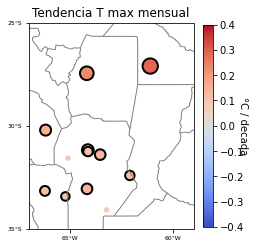

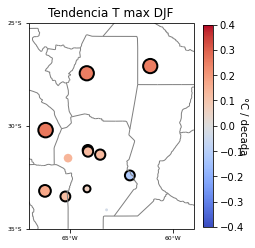

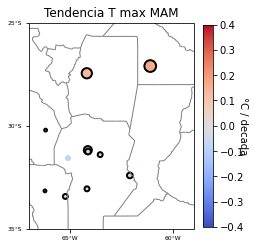

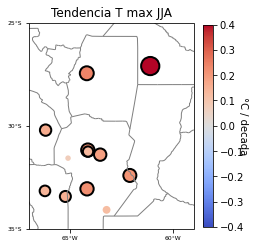

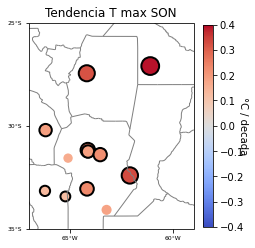

In [103]:
#Recorte de las estaciones

'''Datos mensuales'''
trend = []
pvalue = []
interc = []


for key in EST2:
    
    df = est2_mensual[key]
    mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
    df = df.loc[mask]
    
    t, y, p = linear_trend(df, 'tmax')
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120).round(2))
    pvalue.append(p.round(2))
    interc.append(y.round(2))
    
    del t, y, p

    # Con todos los datos que ya tengo, hago una tabla.

tabla_tmax = pd.DataFrame(list(zip(EST2,  trend, interc,  pvalue)), 
                     columns = ['estacion','tend_mensual','interc_mensual','pvalue_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y pvalue
    trend= []
    pvalue= []
    interc = []
    
    for key in EST2: 
        
        df = dic[key]
        mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
        df = df.loc[mask]
        t, y, p = linear_trend(df, 'tmax')
        

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        pvalue.append(p.round(2))
        interc.append(y.round(2))

        del t, y, p
    
    #Agrego como 
    tabla_tmax[('tend_'+est[-4:-1])] = trend
    tabla_tmax[('interc_'+est[-4:-1])] = interc
    tabla_tmax[('pvalue_'+est[-4:-1])] = pvalue

    del trend, pvalue



tabla_tmax.to_csv(SALIDAS+'Tendencias_1970_2020_tmax.csv')


#Agrego los detalles a cada estación

lista_latitudes = []
lista_longitudes = []

for key in detalles2.keys():
    lista_longitudes.append(360-detalles2[key]['lon'].values[0])
    lista_latitudes.append(detalles2[key]['lat'].values[0]*-1)

tabla_tmax['lat'] = lista_latitudes
tabla_tmax['lon'] = lista_longitudes

print(tabla_tmax)


mapa_tendencias_cmap(tabla_tmax, 'T max', 'coolwarm', '°C / decada')

print(tabla_tmax[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].max())
print(tabla_tmax[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].min())


#### Temperatura minima

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


                estacion  tend_mensual  interc_mensual  pvalue_mensual  \
0    Santiago del Estero          0.23           -0.73            0.00   
1           Cordoba aero          0.17           -0.48            0.00   
2   Cordoba observatorio          0.11           -0.22            0.02   
3     Pilar observatorio          0.14           -0.51            0.00   
4     Villa Dolores aero          0.07           -0.29            0.09   
5        Río Cuarto aero          0.14           -0.61            0.00   
6          San Luis aero          0.12           -0.28            0.00   
7         Laboulaye aero          0.07           -0.42            0.12   
8    Villa Reynolds aero          0.09           -0.23            0.04   
9      Marco Juarez aero          0.11           -0.26            0.01   
10              Chamical          0.15           -0.36            0.00   
11            Las Breñas          0.29           -0.78            0.00   

    tend_DJF  interc_DJF  pvalue_DJF 

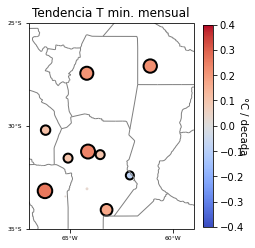

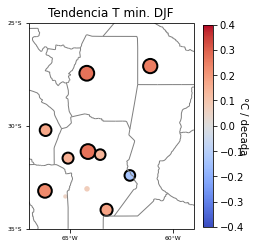

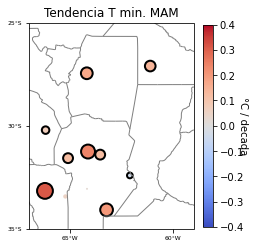

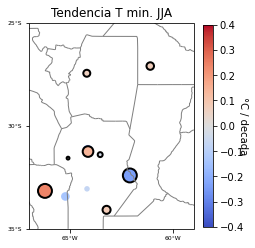

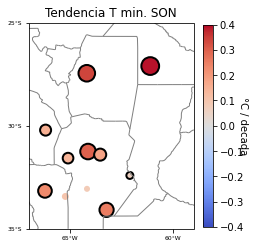

In [104]:
#Recorte de las estaciones

'''Datos mensuales'''
trend = []
pvalue = []
interc = []

for key in EST2:
    
    df = est2_mensual[key]
    mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
    df = df.loc[mask]
    
    t, y, p = linear_trend(df, 'tmin')
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120).round(2))
    pvalue.append(p.round(2))
    interc.append(y.round(2))
    
    del t, y, p

    # Con todos los datos que ya tengo, hago una tabla.

tabla_tmin = pd.DataFrame(list(zip(EST2, trend, interc, pvalue)), 
                     columns = ['estacion','tend_mensual','interc_mensual','pvalue_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y pvalue
    trend= []
    pvalue= []
    interc= []
    
    for key in EST2: 
        
        df = dic[key]
        mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
        df = df.loc[mask]
        t, y, p = linear_trend(df, 'tmin')
        

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        pvalue.append(p.round(2))
        interc.append(y.round(2))

        del t, y, p
    
    #Agrego como 
    tabla_tmin[('tend_'+est[-4:-1])] = trend
    tabla_tmin[('interc_'+est[-4:-1])] = interc
    tabla_tmin[('pvalue_'+est[-4:-1])] = pvalue

    del trend, pvalue

#print(tabla_tmin)

tabla_tmin.to_csv(SALIDAS+'Tendencias_1970_2020_tmin.csv')

#Agrego los detalles a cada estación

tabla_tmin['lat'] = lista_latitudes
tabla_tmin['lon'] = lista_longitudes

print(tabla_tmax)

'''
MAPA DE CORRELACIONES
'''

mapa_tendencias_cmap(tabla_tmin, 'T min.', 'coolwarm', '°C / decada')

print(tabla_tmin[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].max())
print(tabla_tmin[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].min())

#### Precipitación

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


                estacion  tend_mensual  interc_mensual  pvalue_mensual  \
0    Santiago del Estero         -3.99        5.831398            0.79   
1           Cordoba aero        -14.13        4.768063            0.39   
2   Cordoba observatorio         -3.68        2.950475            0.83   
3     Pilar observatorio        -37.19       11.026834            0.02   
4     Villa Dolores aero          2.33        2.999247            0.85   
5        Río Cuarto aero        -12.15        5.479409            0.45   
6          San Luis aero         19.20        2.560771            0.15   
7         Laboulaye aero         15.37        0.045328            0.39   
8    Villa Reynolds aero          4.10        1.150014            0.78   
9      Marco Juarez aero         -5.74        4.886615            0.75   
10              Chamical          0.25        0.641085            0.98   
11            Las Breñas         -9.27        2.919046            0.62   

    tend_DJF  interc_DJF  pvalue_DJF 

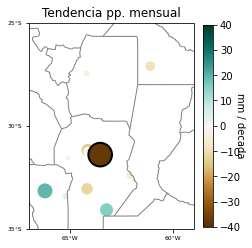

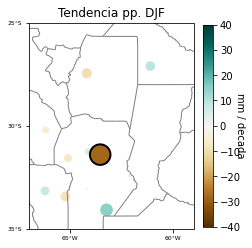

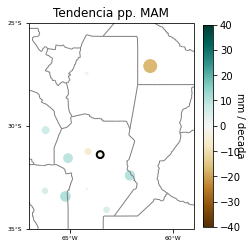

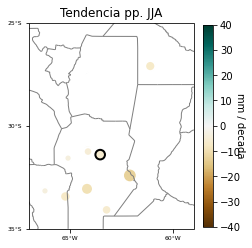

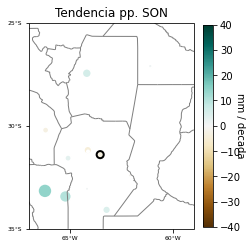

In [105]:
#Recorte de las estaciones

'''Datos mensuales'''
trend = []
pvalue = []
interc = []


for key in EST2:
    
    df = est2_mensual[key]
    mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
    df = df.loc[mask]
    
    t, y, p = linear_trend(df, 'pp')
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120*12).round(2))
    pvalue.append(p.round(2))
    interc.append(y)
    
    del t, y, p

    # Con todos los datos que ya tengo, hago una tabla.

tabla_pp = pd.DataFrame(list(zip(EST2, trend, interc,  pvalue)), 
                     columns = ['estacion','tend_mensual','interc_mensual','pvalue_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y pvalue
    trend= []
    pvalue= []
    interc= []
    
    for key in EST2: 
        
        df = dic[key]
        mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
        df = df.loc[mask]
        t, y, p = linear_trend(df, 'pp')
        

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        pvalue.append(p.round(2))
        interc.append(y)

        del t, y, p
    
    #Agrego como columna nueva, usando el string del nombre
    tabla_pp[('tend_'+est[-4:-1])] = trend
    tabla_pp[('interc_'+est[-4:-1])] = interc
    tabla_pp[('pvalue_'+est[-4:-1])] = pvalue

    del trend, pvalue


tabla_pp.to_csv(SALIDAS+'Tendencias_1970_2020_pp.csv')

#Agrego latitudes y longitudes
tabla_pp['lat'] = lista_latitudes
tabla_pp['lon'] = lista_longitudes

print(tabla_pp)

'''
MAPA DE CORRELACIONES
'''
mapa_tendencias_cmap(tabla_pp, 'pp.', 'BrBG', 'mm / decada', precip=True)

print(tabla_pp[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].max())
print(tabla_pp[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].min())

## Tendencia de Sen

Esta tendencia se obtiene calculando la tendencia lineal en todos los pares de puntos de la serie, se ordenan de menor a mayor, y la pendiente de Sen será la mediana de todas las pendientes. 
No se ve afectado por los outliers o extremos como lo hace una regresión lineal de cuadrados minimos. Es recomendado por la OMM para datos hidrometeorológicos (Aditya et al 2021).

### Temperatura máxima

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


                estacion  tend_mensual  interc_mensual  tend_DJF  interc_DJF  \
0    Santiago del Estero          0.24           -0.76      0.29       -1.07   
1           Cordoba aero          0.20           -0.54      0.22       -0.68   
2   Cordoba observatorio          0.13           -0.25      0.26       -0.81   
3     Pilar observatorio          0.16           -0.58      0.26       -1.51   
4     Villa Dolores aero          0.08           -0.27      0.17       -0.84   
5        Río Cuarto aero          0.17           -0.69      0.16       -1.24   
6          San Luis aero          0.15           -0.29      0.23       -0.79   
7         Laboulaye aero          0.12           -0.62      0.09       -0.96   
8    Villa Reynolds aero          0.12           -0.24      0.16       -0.44   
9      Marco Juarez aero          0.12           -0.38     -0.06       -0.20   
10              Chamical          0.17           -0.40      0.29       -0.80   
11            Las Breñas          0.28  

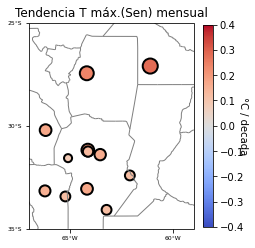

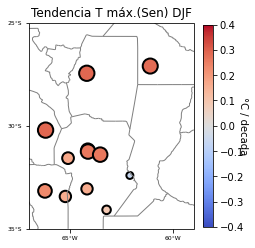

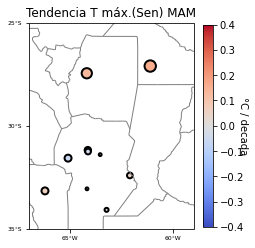

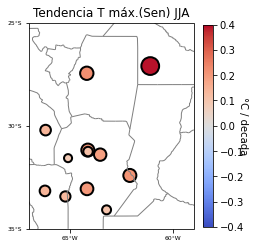

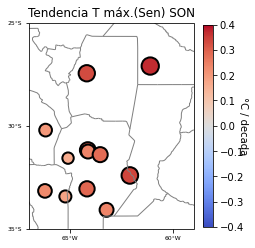

In [106]:
#Recorte de las estaciones

'''Datos mensuales'''

trend = []
interc = []


for key in EST2:
    
    df = est2_mensual[key]
    mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
    df = df.loc[mask]
    
    t, y = linear_trend(df, 'tmax', sen=True)
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120).round(2))
    interc.append(y.round(2))
    
    del t, y

    # Con todos los datos que ya tengo, hago una tabla.

tabla_tmax = pd.DataFrame(list(zip(EST2,  trend,  interc)), 
                     columns = ['estacion','tend_mensual','interc_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y interc
    trend= []
    interc= []
    
    for key in EST2: 
        
        df = dic[key]
        mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
        df = df.loc[mask]
        t, y= linear_trend(df, 'tmax', sen=True)
        

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        interc.append(y.round(2))

        del t, y
    
    #Agrego como 
    tabla_tmax[('tend_'+est[-4:-1])] = trend
    tabla_tmax[('interc_'+est[-4:-1])] = interc
    tabla_tmax[('pvalue_'+est[-4:-1])] = 0.049

    del trend, interc


tabla_tmax['pvalue_mensual'] = 0.049

tabla_tmax.to_csv(SALIDAS+'Tendencias_TheilSen_1970_2020_tmax.csv')


#Agrego los detalles a cada estación

lista_latitudes = []
lista_longitudes = []

for key in detalles2.keys():
    lista_longitudes.append(360-detalles2[key]['lon'].values[0])
    lista_latitudes.append(detalles2[key]['lat'].values[0]*-1)

tabla_tmax['lat'] = lista_latitudes
tabla_tmax['lon'] = lista_longitudes

print(tabla_tmax)

'''
MAPA DE CORRELACIONES
'''
mapa_tendencias_cmap(tabla_tmax, 'T máx.(Sen)', 'coolwarm', '°C / decada')

print(tabla_tmax[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].max())
print(tabla_tmax[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].min())


### Temperatura minima

/home/dalia.panza/anaconda3/envs/env1/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


                estacion  tend_mensual  interc_mensual  tend_DJF  interc_DJF  \
0    Santiago del Estero          0.22           -0.33      0.27       -0.46   
1           Cordoba aero         -0.01            0.05      0.04       -0.01   
2   Cordoba observatorio          0.25           -0.44      0.29       -0.57   
3     Pilar observatorio          0.10            0.14      0.14        0.15   
4     Villa Dolores aero          0.11           -0.12      0.15       -0.23   
5        Río Cuarto aero          0.04            0.41      0.08        0.30   
6          San Luis aero          0.29           -0.29      0.25       -0.35   
7         Laboulaye aero          0.19           -0.42      0.18       -0.40   
8    Villa Reynolds aero          0.02            0.03      0.05        0.09   
9      Marco Juarez aero         -0.07            0.27     -0.15        0.57   
10              Chamical          0.10           -0.22      0.16       -0.38   
11            Las Breñas          0.23  

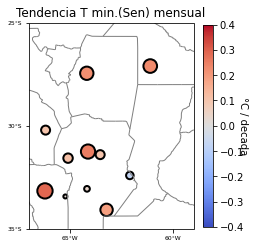

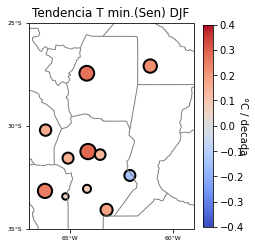

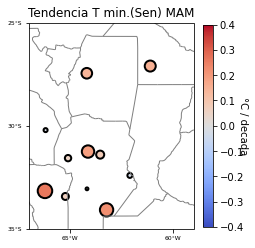

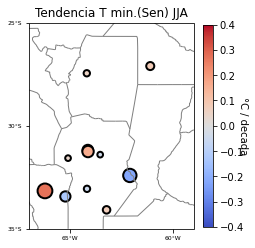

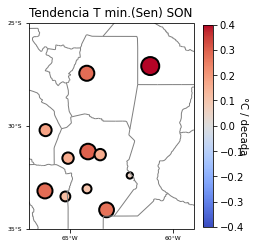

In [107]:
#Recorte de las estaciones

'''Datos mensuales'''
trend = []
interc = []


for key in EST2:
    
    df = est2_mensual[key]
    mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
    df = df.loc[mask]
    
    t, y = linear_trend(df, 'tmin', sen=True)
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120).round(2))
    interc.append(y.round(2))
    
    del t, y

    # Con todos los datos que ya tengo, hago una tabla.

tabla_tmin = pd.DataFrame(list(zip(EST2,  trend,  interc)), 
                     columns = ['estacion','tend_mensual','interc_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y interc
    trend= []
    interc= []
    
    for key in EST2: 
        
        df = dic[key]
        mask = ((df['date'] > pd.to_datetime('1969-12-31')) & (df['date'] < pd.to_datetime('2021-1-1')))
        df = df.loc[mask]
        t, y= linear_trend(df, 'tmin', sen=True)
        

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        interc.append(y.round(2))

        del t, y
    
    #Agrego como 
    tabla_tmin[('tend_'+est[-4:-1])] = trend
    tabla_tmin[('interc_'+est[-4:-1])] = interc
    tabla_tmin[('pvalue_'+est[-4:-1])] = 0.049

    del trend, interc

tabla_tmin['pvalue_mensual'] = 0.049

tabla_tmin.to_csv(SALIDAS+'Tendencias_TheilSen_1970_2020_tminx.csv')
print(tabla_tmin)


#Agrego los detalles a cada estación

lista_latitudes = []
lista_longitudes = []

for key in detalles2.keys():
    lista_longitudes.append(360-detalles2[key]['lon'].values[0])
    lista_latitudes.append(detalles2[key]['lat'].values[0]*-1)

tabla_tmin['lat'] = lista_latitudes
tabla_tmin['lon'] = lista_longitudes

'''
MAPA DE CORRELACIONES
'''
mapa_tendencias_cmap(tabla_tmin, 'T min.(Sen)', 'coolwarm', '°C / decada')

print(tabla_tmin[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].max())
print(tabla_tmin[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].min())


### Precipitación


                estacion                  periodo  tend_mensual  porcentaje  \
0    Santiago del Estero  1931-01-01 - 2021-09-01          8.75        0.16   
1           Cordoba aero  1956-02-01 - 2021-09-01          1.15        0.02   
2   Cordoba observatorio  1956-05-01 - 2021-09-01          1.81        0.04   
3     Pilar observatorio  1925-02-01 - 2021-09-01         -0.29       -0.01   
4     Villa Dolores aero  1930-01-01 - 2021-09-01         11.35        0.17   
5        Río Cuarto aero  1931-01-01 - 2021-09-01          3.95        0.06   
6          San Luis aero  1931-01-01 - 2021-09-01         14.09        0.13   
7         Laboulaye aero  1939-09-01 - 2021-09-01         15.62        0.35   
8    Villa Reynolds aero  1956-02-01 - 2021-09-01          7.25        0.41   
9      Marco Juarez aero  1952-07-01 - 2021-09-01         19.01        1.64   
10              Chamical  1962-11-01 - 2021-09-01          4.18        0.09   
11            Las Breñas  1967-01-01 - 2022-01-01   

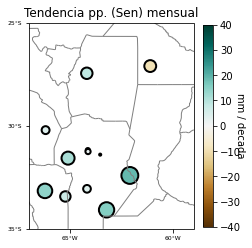

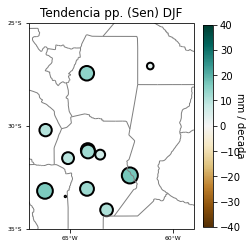

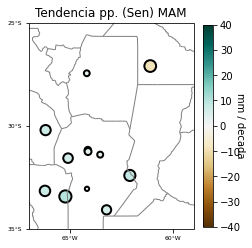

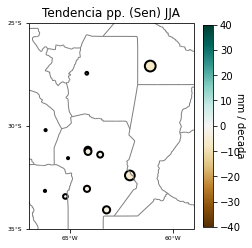

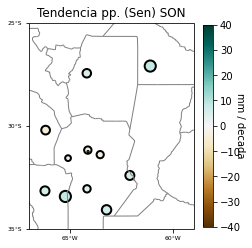

In [108]:
'''Datos mensuales'''

trend = []
interc = []
porcentaje = []


for key in EST2:
    
    t, y= linear_trend(est2_mensual[key], 'pp', sen=True)
    
    #Multiplico la tendencia por 120 para obtener la tendencia/decada
    trend.append((t*120*12).round(2))
    interc.append(y.round(2))

    
    #Calculo la precipitación media 1980-2010 para ver que % representa la tendencia
    df = est2_mensual[key]
    mask = ((df['date'] > pd.to_datetime('1979-12-31')) & (df['date'] < pd.to_datetime('2011-1-1')))
    df = df.loc[mask]
    media = df['pp'].mean()
    porc = (t/media)*100

    porcentaje.append(porc.round(2))
    
    del t,y, porc
    
# Con todos los datos que ya tengo, hago una tabla.

tabla_pp = pd.DataFrame(list(zip(EST2, periodos, trend, porcentaje, interc)), 
                     columns = ['estacion','periodo','tend_mensual','porcentaje','interc_mensual'])

'''Datos estacionales'''
#Calculo la tendencia
for est in KEYS:
    
    #Selecciono la estación del año
    dic = est2_anom_est[est]
    
    #Hago dos listas vacías para almacenar las tendencias y interc
    trend= []
    interc= []
    porcentaje=[]
    
    for key in EST2: 
        t, y = linear_trend(dic[key], 'pp', sen=True)

        #Multiplico la tendencia por 10 para obtener la tendencia/decada
        trend.append((t*10).round(2))
        interc.append(y.round(2))

       
        #Calculo la precipitación media 1980-2010 para ver que % representa la tendencia
        df = dic[key]
        mask = ((df['date'] > pd.to_datetime('1979-12-31')) & (df['date'] < pd.to_datetime('2011-1-1')))
        df = df.loc[mask]
        media = df['pp'].mean()
        porc = (t/media)*100
    
        porcentaje.append(porc.round(2))
        
    #Agrego columnas  con la tendencia, porcentaje y significancia
    tabla_pp[('tend_'+est[-4:-1])] = trend
    tabla_pp[('porcentaje_'+est[-4:-1])] = porcentaje
    tabla_pp[('interc_'+est[-4:-1])] = interc
    tabla_pp[('pvalue_'+est[-4:-1])] = 0.049


    del trend, interc, porcentaje, t, y, porc

print(tabla_pp)
tabla_pp['pvalue_mensual'] = 0.049

tabla_pp.to_csv(SALIDAS+'Tendencias_TheilSen_pp.csv')

#Agrego latitudes y longitudes
tabla_pp['lat'] = lista_latitudes
tabla_pp['lon'] = lista_longitudes

'''
MAPA DE CORRELACIONES
'''
mapa_tendencias_cmap(tabla_pp, 'pp. (Sen)', 'BrBG', 'mm / decada', precip=True)

print(tabla_pp[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].max())
print(tabla_pp[['tend_mensual', 'tend_DJF', 'tend_MAM', 'tend_JJA', 'tend_SON']].min())


del tabla_pp
